# Logistic Regression Analysis: Determinants of Women as Primary Source of Revenue


---

![banner](banner.jpg)

---

## Content Table
- [0. Environment Setup](#0.-Environment-Setup)
- [1. Data Exploration & Management](#1.-Data-Exploration-&-Management)
- [2. Feature Selection](#2.Feature-Selection)
  - [A. Quantitative Data](#A.-Quantitative-Data)
  - [B. Qualitative Data](#B.-Qualitative-Data)
- [3. Final Data Preparation](#3.-Final-Data-Preparation)
- [4. Statistical Modeling](#4.-Statistical-Modeling)
  - [A. Multicollinearity tests](#A.-Multicollinearity-tests)
  - [B. Data Standardization](#B.-Data-Standardization)
  - [C. Model creation & fitting](#C.-Model-creation-&-fitting)
  - [D. Model Optimization](#D.-Model-Optimization)
  - [E. Model testing](#E.-Model-testing)
- [5. Conclusion](#5.-Conclusion)

## Project Overview

This project aims to analyze the determinants for a woman being the primary source of revenue in a household using data from the "Conditions de Travail 2013" survey. The analysis will be focused on individuals living in couples in the same household.

### Objectives
The objective of the project is to analyze, based on the 2013 Working Conditions survey, the determinants for a woman being the primary source of revenue in the household.
1. Data Exploration & Management: Explore the dataset and the available data and handle missing data.
2. Feature Selection: The dataset presents 541 Columns/Features. A selection needs to be made to be able to conduct further analysis.
3. Build and evaluate a logistic regression model to identify significant predictors of a women being the primary source of revenue in the household.

### Dataset

- **Source**: Conditions de Travail 2013 (Volet "Actif")
- **Initial Dataset Size**: 33,673 individuals
- **Filtered Dataset**: Individuals living in couples at the same household

### Dependencies

- Python libraries: pandas, numpy, matplotlib, seaborn, statsmodels, scikit-learn, plotly, scipy

---

## 0. Environment Setup

In [ ]:
# Import necessary librairies
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [ ]:
dataset_path = "Data/individus_ct2013.sas7bdat"

---

## 1. Data Exploration & Management

In [ ]:
# Load the data from the 'individus_ct2013.sas7bdat' file into a DataFrame named df
df = pd.read_sas(dataset_path, format="sas7bdat", encoding="latin-1")

# Display the DataFrame
df.head(3)

,C1C,C1D,IDENT_MEN,IDENT_IND,NPERS,NACTIFS,TYPMEN5,TYPMEN15,IR,REVMEN,...,lnaisd,lnaisper,lnaismer,natnaisper,natnaismer,nati,revannu_drap,revannu,revmensc,revmenscc_drap
0,2,2,0100019101000,010001910100002,2.0,1.0,2,22,1,2200.0,...,11,11,11,NaN,NaN,NaN,1.0,1500.0,125.0,1.0
1,NaN,NaN,0100083001000,010008300100002,2.0,2.0,5,52,2,2250.0,...,11,11,11,NaN,NaN,NaN,-2.0,NaN,NaN,-2.0
2,2,2,0100084601000,010008460100002,5.0,2.0,4,42,1,2300.0,...,11,11,11,NaN,NaN,NaN,1.0,0.0,0.0,1.0


##### This analysis will be only based on couples living in the same household. This is represented by the value 1 in the **'COUPLE'** variable.

In [ ]:
# Filter only persons in couple in the same household for the study
df = df[df["COUPLE"] == "1"]
df.shape

(24024, 541)

##### Creation of the target variable: A binary variable that represents whether a Women is the primary source of revenue in the household

In [ ]:
# Creat new variable 'target', this target represent women (in couple) who are the primary source of revenue in their household
df["target"] = df[["SEXE", "PRACT"]].apply(
    lambda x: True if x.iloc[0] == "1" and x.iloc[1] == "1" else False, axis=1
)

# Counts number of each category NOT PROVIDING (False) vs PROVIDING (True)
df["target"].value_counts()

/tmp/ipykernel_160722/3477372514.py:2: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



target
False    14629
True      9395
Name: count, dtype: int64

##### The columns PRACT and SEXE are now represented as needed by the **'target'** variable. 'LIENPREF' is not needed as well

In [ ]:
# Dropping useless columns
df = df.drop(columns=["PRACT", "SEXE", "LIENPREF"])

##### Analysis of the columns types

In [ ]:
# Display the distribution of the target variable and thus the distribution of quantitative and qualitative variables
df.dtypes.value_counts()

object     462
float64     76
bool         1
Name: count, dtype: int64

---

## 2.Feature Selection

#### Our primary feature selection will be based on the relation of the columns with our target variables. The data set has both **Qualitative** & **Quantitative** data which will be explored seperatly at this stage.

### A. Quantitative Data

In [ ]:
# Get quantitative variables to calculate pearson correlation
quantitatives = df.select_dtypes(include=["float64", "int64"])
quantitatives.shape

(24024, 76)

#### Analysis of the missing values:

In [ ]:
quantitatives.isna().sum().sort_values(ascending=False)

SUPA               23928
TPSINT             23777
tps_interim        23777
SUPH               23336
duree_cessation    23280
                   ...  
AGE                    0
ANAIS                  0
MNAIS                  0
COEFFUC                0
revmenscc_drap         0
Length: 76, dtype: int64

In [ ]:
px.bar(
    quantitatives.isna().sum().sort_values(ascending=False),
    title="Number of missing values in the qualitative variables",
)

##### We chose to fill the missing values with medians to be able to study their correlation. The median was chosen rather then a mean to avoid any bias that could be introduced by outliers.

In [ ]:
quantitatives.fillna(quantitatives.median(), inplace=True)

In [ ]:
# Copy the target variable to the quantitatives DataFrame
quantitatives["target"] = df["target"]

#### Correlation Analysis:

##### We use pearson correlation coefficient to analyze the correlation between the variables and our target variable. Scipy was used rather than pandas correlation function so that we can extract and use the pvalue as well.

In [ ]:
from scipy.stats import pearsonr

# Calculate Correlation of all quantitative variables with target variable
quantitative_corr = {
    "Column": [],
    "Correlation": [],
    "P-value": [],
}  # Create a dictionary to store the results
for col in quantitatives.columns:
    corr, pvalue = pearsonr(
        quantitatives[col], quantitatives["target"]
    )  # Calculate the correlation and p-value using the pearsonr function
    quantitative_corr["Column"].append(col)
    quantitative_corr["Correlation"].append(corr)
    quantitative_corr["P-value"].append(pvalue)
# Create a DataFrame from the dictionary and sort it by the correlation and P-value
quant_corr = (
    pd.DataFrame(quantitative_corr)
    .sort_values(by=["Correlation", "P-value"], ascending=False, key=(abs))
    .reset_index()
    .drop(0)
    .drop(columns="index")
)

In [ ]:
quant_corr

,Column,Correlation,P-value
1,HH,0.268071,0.000000e+00
2,KMANNU,0.205376,4.007308e-227
3,JOURTR,0.190734,1.334825e-195
4,NBRKM,0.181284,1.392872e-176
5,CJACTOCCUP,-0.167778,3.490268e-151
...,...,...,...
72,INFOH,0.002117,7.427827e-01
73,DATACCM,-0.001456,8.214214e-01
74,ANARRIV,0.001345,8.348608e-01
75,POURCLIEN,-0.000870,8.927699e-01


##### We apply a filter on the resulting data frame to keep only relevant correlations (**'P-value'<0.05**) and those having a (**correlation coefficient > 0.1**) in absolute value.

In [ ]:
quant_corr_filtered = quant_corr[
    (quant_corr["P-value"] < 0.05) & (abs(quant_corr["Correlation"]) > 0.1)
]

In [ ]:
fig = px.bar(
    quant_corr_filtered,
    x="Column",
    y="Correlation",
    color=abs(quant_corr_filtered["Correlation"]),
    text="Correlation",
    color_continuous_scale=px.colors.sequential.Blues,
    title="Pearson Correlation of the quantitative variables with the target variable",
)
fig.update_traces(texttemplate="%{text:.2f}", textposition="inside")
fig.update_layout(
    xaxis_title="Quantitative Variables",
    yaxis_title="Pearson Correlation",
    title_x=0.5,  # Center the title
    coloraxis_colorbar=dict(
        title="Absolute Correlation"
    ),
    uniformtext_minsize=8,
    uniformtext_mode='hide'
)
fig.show()

##### Using the dictionnary we analyzed the meaning/content of these variables and found recurrent ones that we eliminated

In [ ]:
quant_corr_filtered = (
    quant_corr_filtered.set_index("Column") # Set the column as the index 
    .drop(["JOURTR", "CJACTOCCUP", "revmensc", "NBRKM"]) 
    .reset_index()
)
quant_corr_filtered

,Column,Correlation,P-value
0,HH,0.268071,0.000000e+00
1,KMANNU,0.205376,4.007308e-227
2,REVMENS,0.115248,7.969893e-72


##### We also found that one of the variables **'CJACTOCCUP'** is a qualitative one 

In [ ]:
df["CJACTOCCUP"] = df["CJACTOCCUP"].apply(lambda x: str(x)) # Convert the column to string

---

### B. Qualitative Data

In [ ]:
# Get qualitative variables to calculate chi² correlation
qualitatives = df.select_dtypes(include=["object"])
qualitatives.shape

(24024, 463)

In [ ]:
# Copy the target variable to the qualitatives DataFrame
qualitatives["target"] = df["target"]

#### Analysis of the missing values:

In [ ]:
qualitatives.isna().sum().sort_values(ascending=False)

LIEN_20    24024
LIEN_19    24024
LIEN_18    24023
LIEN_16    24021
LIEN_17    24021
           ...  
RISQUAL        0
RISFINA        0
RISDANG        0
RISEMPL        0
target         0
Length: 464, dtype: int64

In [133]:
# Create the bar chart
fig = px.bar(
    qualitatives.isna().sum().sort_values(ascending=False),
    title="Number of Missing Values in the Quantitative Variables",
    labels={
        "Variable": "Quantitative Variables",
        "MissingValues": "Number of Missing Values",
    },
)

# Update layout for better readability
fig.update_layout(
    xaxis_title="Quantitative Variables",
    yaxis_title="Number of Missing Values",
    title_x=0.5,  # Center the title
    xaxis_tickangle=-45,
    showlegend=False,
)

##### From the graph we decided to drop all columns with more than 2000 missing values as those could negatively impact the analysis and could not be used to calculate the relation to the target variable

In [134]:
qualitatives.shape

(24024, 464)

In [135]:
qualitatives = qualitatives.dropna(axis=1, thresh=(len(df) - 2000)).dropna() # Drop columns with more than 2000 missing values then finally drop the rows with missing values

In [136]:
qualitatives.shape

(18418, 302)

#### Correlation Analysis:

##### We used the chi2 test to determine whether there is a realtion between the qualitative variables and our target variable for feature selection. The process is generally the same as the one we used for the quantitative variables.

In [137]:
from scipy.stats import chi2_contingency

# Calculate Correlation of all qualitative variables with target variable
qualitative_corr = {
    "Column": [],
    "Chi2-stat": [],
    "P-value": [],
    "dof": [],
    "expected": [],
}
for col in qualitatives.columns:
    contingency_table = pd.crosstab(qualitatives[col], qualitatives["target"]) # Create a contingency table using the crosstab function
    cchi2_stat, p_val, dof, expected = chi2_contingency(contingency_table) # Calculate the chi2 statistic, p-value, degrees of freedom and expected values using the chi2_contingency function
    qualitative_corr["Column"].append(col)
    qualitative_corr["Chi2-stat"].append(cchi2_stat)
    qualitative_corr["P-value"].append(p_val)
    qualitative_corr["dof"].append(dof)
    qualitative_corr["expected"].append(expected)

# Create a DataFrame from the dictionary and sort it by the chi2 statistic and P-value
quali_corr = (
    pd.DataFrame(qualitative_corr)
    .sort_values(by=["Chi2-stat", "P-value"], ascending=False, key=(abs))
    .reset_index()
    .drop(0)
    .drop(columns="index")[1:]
)

In [138]:
quali_corr

,Column,Chi2-stat,P-value,dof,expected
2,IDENT_FA,11694.082450,1.0,14338,"[[0.6172765772613747, 0.38272342273862525], [0..."
3,IDENT_LOG,11694.082450,1.0,14338,"[[0.6172765772613747, 0.38272342273862525], [0..."
4,IDENT_MEN,11694.082450,1.0,14350,"[[0.6172765772613747, 0.38272342273862525], [0..."
5,PE,6422.827119,0.0,498,"[[4.320936040829623, 2.6790639591703767], [0.6..."
6,peun,6145.467554,0.0,370,"[[10.493701813443371, 6.506298186556629], [10...."
...,...,...,...,...,...
297,REPQAA,0.000000,1.0,0,"[[11369.0, 7049.0]]"
298,TPSINT_DRAP,0.000000,1.0,1,"[[11368.38272342274, 7048.617276577262], [0.61..."
299,DATANT_DRAP,0.000000,1.0,1,"[[11363.444510804648, 7045.5554891953525], [5...."
300,EC,0.000000,1.0,0,"[[11369.0, 7049.0]]"


##### We apply a filter on the resulting data frame to keep only relevant correlations (**'P-value'<0.05**). Seeing there still way to many variables we select the 50 first with the strongest chi2_stat

In [139]:
filtered_quali_corr = quali_corr[(quali_corr["P-value"] < 0.05)][:50]

In [140]:
# Create a new column with the number of categories for each qualitative variable 
filtered_quali_corr["Number of categories"] = [
    len(qualitatives[col].unique()) for col in filtered_quali_corr["Column"]
]

In [141]:
fig = px.bar(
    filtered_quali_corr,
    x="Column",
    y="Chi2-stat",
    text="Chi2-stat",
    color="Number of categories",
    color_continuous_scale=px.colors.sequential.Blues_r,
    title="Chi2 Correlation of the quantitative variables with the target variable",
)
fig.update_traces(texttemplate="%{text:.2f}", textposition="inside")
fig.update_layout(
    title_x=0.5,  # Center the title
)
fig.show()

#### One Hot Encoding:

##### Since we use categorical variables that are label encoded, we one hot encoded them to be able to use Linear Regression models without ordinality problems. 

In [142]:
one_hot_quali = pd.get_dummies(
    qualitatives[filtered_quali_corr["Column"].to_list()],
    prefix=filtered_quali_corr["Column"].to_list(),
)
one_hot_quali["target"] = df["target"]
one_hot_quali

,PE_0000,PE_0003,PE_111A,PE_111B,PE_111C,PE_111D,PE_111E,PE_111F,PE_121A,PE_121B,...,DELAIS_1,DELAIS_2,DELAIS_3,DELAIS_9,INCIDENT_1,INCIDENT_2,INCIDENT_3,INCIDENT_8,INCIDENT_9,target
9,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,True,False,False,False,False,True
11,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,True,False,False,False,False,False
15,False,False,True,False,False,False,False,False,False,False,...,False,False,True,False,True,False,False,False,False,True
21,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,True
26,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33665,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,True,False,False,False,False,False
33666,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,True,False,False,False,False,True
33667,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,True,False,False,False,False,True
33668,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,True,False,False,False,False,True


#### Second Correlation Analysis

##### We perform a second relation analysis similar to the previous one on the values of the selected columns 

In [143]:
# Calculate Correlation of all qualitative variables with target variable
oh_qualitative_corr = {
    "Column": [],
    "Chi2-stat": [],
    "P-value": [],
    "dof": [],
    "expected": [],
}
for col in one_hot_quali.columns:
    contingency_table = pd.crosstab(one_hot_quali[col], one_hot_quali["target"])
    cchi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
    oh_qualitative_corr["Column"].append(col)
    oh_qualitative_corr["P-value"].append(p_val)
    oh_qualitative_corr["dof"].append(dof)
    oh_qualitative_corr["expected"].append(expected)
    oh_qualitative_corr["Chi2-stat"].append(cchi2_stat)

# Create a DataFrame from the dictionary and sort it by the chi2 statistic and P-value
one_hot_quali_corr = (
    pd.DataFrame(oh_qualitative_corr)
    .sort_values(by=["Chi2-stat", "P-value"], ascending=False, key=(abs))
    .reset_index()
    .drop(0)
    .drop(columns="index")[1:]
)

In [144]:
one_hot_quali_corr

,Column,Chi2-stat,P-value,dof,expected
2,TPP_1,1796.127392,0.000000e+00,1,"[[2183.3072537734824, 1353.6927462265176], [91..."
3,SECROUT_1,1479.867368,0.000000e+00,1,"[[7437.565479422305, 4611.434520577695], [3931..."
4,SECROUT_2,1474.633121,0.000000e+00,1,"[[3934.5209034640025, 2439.4790965359975], [74..."
5,cser_5,1377.926440,1.315491e-301,1,"[[8042.496525138452, 4986.503474861548], [3326..."
6,naf4_EV,1361.400263,5.132368e-298,1,"[[2291.9479313714846, 1421.0520686285156], [90..."
...,...,...,...,...,...
1567,HYGSAL_8,0.000000,1.000000e+00,1,"[[11368.38272342274, 7048.617276577262], [0.61..."
1568,HYGSAL_9,0.000000,1.000000e+00,1,"[[11364.67906395917, 7046.32093604083], [4.320..."
1569,SECACCID_8,0.000000,1.000000e+00,1,"[[11367.765446845477, 7048.2345531545225], [1...."
1570,SECINFEC_8,0.000000,1.000000e+00,1,"[[11368.38272342274, 7048.617276577262], [0.61..."


##### We apply a filter on the resulting data frame to keep only relevant correlations (**'P-value'<0.05**). Seeing there still way to many variables we select the 20 first with the strongest chi2_stat

In [145]:
filtered_oh_quali_corr = one_hot_quali_corr[(one_hot_quali_corr["P-value"] < 0.05)][:20]

In [146]:
fig = px.bar(
    filtered_oh_quali_corr,
    x="Column",
    y="Chi2-stat",
    text="Chi2-stat",
    color_discrete_sequence=px.colors.sequential.Blues_r,
    title="Chi2 Correlation of the quantitative variables with the target variable",
)
fig.update_traces(texttemplate="%{text:.2f}", textposition="inside")
fig.update_layout(
    title_x=0.5,  # Center the title
)
fig.show()

---

## 3. Final Data Preparation

##### First we create a dataframe with the selected qualitative and quantitative variables

In [147]:
df_filtered = df[
    filtered_quali_corr["Column"].to_list()
    + quant_corr_filtered["Column"].to_list()
    + ["target"]
]
df_filtered

,PE,peun,fap225,fap87,CSE,csei,ACTIVFIN,naf38,cser,peun10,...,SOIR,PUBLIC,SECINFEC,DEMPRO,DELAIS,INCIDENT,HH,KMANNU,REVMENS,target
2,111F,6113,A0Z00,A0Z,11,10,01,AZ,1,6,...,2,1,1,2,2,3,66.0,3666.0,NaN,False
3,111F,6114,A0Z00,A0Z,11,10,NaN,00,1,6,...,3,1,1,2,3,1,40.0,NaN,NaN,True
5,111F,6114,A0Z00,A0Z,11,10,01,AZ,1,6,...,3,1,2,1,3,1,40.0,NaN,NaN,True
6,111A,6111,A0Z00,A0Z,11,10,01,AZ,1,6,...,3,2,1,2,1,1,40.0,1410.0,NaN,False
7,111A,6111,A0Z00,A0Z,11,10,01,AZ,1,6,...,3,2,2,2,2,1,70.0,NaN,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33667,5300,9,ZZZZZ,ZZZ,53,51,84,OZ,5,9,...,1,1,2,1,3,1,36.0,NaN,1400.0,True
33668,4000,3115,ZZZZZ,ZZZ,40,40,35,DZ,4,3,...,3,2,2,2,1,1,35.0,30000.0,NaN,True
33669,4600,3,ZZZZZ,ZZZ,46,46,78,NZ,4,3,...,3,2,2,2,2,2,39.0,NaN,NaN,False
33671,2100,7549,ZZZZZ,ZZZ,21,21,43,FZ,2,7,...,3,1,1,2,1,1,38.0,11000.0,NaN,True


In [148]:
df_filtered.isna().sum().sum()

23766

##### We fill the numerical NaNs with a median

In [149]:
# Select the quantitative variables and fill the missing values with the median
df_filtered[df_filtered.select_dtypes(["int", "float"]).columns] = ( 
    df_filtered.select_dtypes(["int", "float"]).fillna(
        df_filtered.select_dtypes(["int", "float"]).median()
    )
)

/tmp/ipykernel_160722/1181171266.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [150]:
df_filtered.isna().sum().sum()

3209

##### We find a small number of missing values in the selected qualitative variables

In [151]:
df_filtered.select_dtypes(include=["object"]).isna().sum().sort_values(ascending=False)

A2I            1296
A2E            1296
TPP             187
DEMPRO          133
TINA            131
ACTIVFIN        123
peun10           13
peun             13
CJSITUA           4
PE                3
CSE               3
cser              3
SOIR              1
NUIT              1
SAMEDI            1
PTMATIN           1
NBNUIT_DRAP       0
NBASTR_DRAP       0
SSECH             0
ASTREINTE         0
SECINFEC          0
SECACCID          0
HYGSAL            0
PUBLIC            0
HYGCOUR           0
DIPLOME           0
DELAIS            0
CJACTOCCUP        0
DETRESSE          0
MISSION           0
HYGCHUMI          0
TYPMEN15          0
fap225            0
fap87             0
csei              0
naf38             0
naf17             0
SECROUT           0
naf4              0
NBRKM_DRAP        0
CONDUITE          0
STATUT            0
CWVIB             0
TYPEXTFP          0
SECFUPOU          0
TELEPORT          0
ENCADR            0
RISFINA           0
ELIGEXT           0
INCIDENT          0


In [152]:
df_filtered.dropna(inplace=True) # Drop the rows with missing values

/tmp/ipykernel_160722/571476937.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



##### Transform the qualitative variables with a one hot encoding

In [153]:
one_hot_df = pd.get_dummies(
    df_filtered, prefix=df_filtered.select_dtypes(include=["object"]).columns
)

In [154]:
one_hot_df

,HH,KMANNU,REVMENS,target,PE_0000,PE_0003,PE_111A,PE_111B,PE_111C,PE_111D,...,DELAIS_1,DELAIS_2,DELAIS_3,DELAIS_8,DELAIS_9,INCIDENT_1,INCIDENT_2,INCIDENT_3,INCIDENT_8,INCIDENT_9
2,66.0,3666.0,1644.0,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,True,False,False
6,40.0,1410.0,1644.0,False,False,False,True,False,False,False,...,True,False,False,False,False,True,False,False,False,False
9,35.0,5500.0,1200.0,True,False,False,False,False,False,False,...,False,True,False,False,False,True,False,False,False,False
11,5.0,5500.0,1644.0,False,False,False,False,False,False,False,...,True,False,False,False,False,True,False,False,False,False
15,26.0,9400.0,1644.0,True,False,False,True,False,False,False,...,False,False,True,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33667,36.0,5500.0,1400.0,True,False,False,False,False,False,False,...,False,False,True,False,False,True,False,False,False,False
33668,35.0,30000.0,1644.0,True,False,False,False,False,False,False,...,True,False,False,False,False,True,False,False,False,False
33669,39.0,5500.0,1644.0,False,False,False,False,False,False,False,...,False,True,False,False,False,False,True,False,False,False
33671,38.0,11000.0,1644.0,True,False,False,False,False,False,False,...,True,False,False,False,False,True,False,False,False,False


##### Select the quantitative variables and the previously selected qualitative value variables from the one hot encoded dataframe 

In [155]:
one_hot_df = one_hot_df[
    filtered_oh_quali_corr["Column"].to_list()
    + quant_corr_filtered["Column"].to_list()
    + ["target"]
]

---

## 4. Statistical modeling

### A. Multicollinearity tests

##### We analyze the selected variables for collinearity to eliminate highly correlated or associated variables that would badly influence our model. 

In [156]:
# Calculate the correlation matrix
corr_matrix = one_hot_df.corr()
corr_matrix

,TPP_1,SECROUT_1,SECROUT_2,cser_5,naf4_EV,CONDUITE_2,NBRKM_DRAP_ 0,CONDUITE_1,naf17_OQ,CJSITUA_6,...,CWVIB_2,CWVIB_1,SECFUPOU_2,SECFUPOU_1,ACTIVFIN_86,naf38_QA,HH,KMANNU,REVMENS,target
TPP_1,1.000000,0.125718,-0.125640,-0.167049,-0.143424,-0.127877,-0.128077,0.128077,-0.088461,0.071407,...,-0.122111,0.121923,-0.103316,0.103048,-0.056000,-0.056000,0.529593,0.100230,0.123532,0.308664
SECROUT_1,0.125718,1.000000,-0.999123,-0.144906,-0.138219,-0.661175,-0.661096,0.661096,-0.119002,0.062976,...,-0.316881,0.317121,-0.238399,0.238491,-0.136021,-0.136021,0.204578,0.303375,0.031349,0.283972
SECROUT_2,-0.125640,-0.999123,1.000000,0.144802,0.137748,0.661684,0.661605,-0.661605,0.118607,-0.062752,...,0.316669,-0.316661,0.238813,-0.238701,0.135862,0.135862,-0.204726,-0.303152,-0.031431,-0.283617
cser_5,-0.167049,-0.144906,0.144802,1.000000,0.256628,0.181942,0.181808,-0.181808,0.184649,-0.089359,...,0.114477,-0.114215,0.100931,-0.100576,0.085229,0.085229,-0.190228,-0.124125,-0.112451,-0.294126
naf4_EV,-0.143424,-0.138219,0.137748,0.256628,1.000000,0.103048,0.102672,-0.102672,0.470077,-0.108275,...,0.239039,-0.238803,0.313607,-0.313275,0.232267,0.232267,-0.142649,-0.079932,-0.004528,-0.276469
CONDUITE_2,-0.127877,-0.661175,0.661684,0.181942,0.103048,1.000000,0.999434,-0.999434,0.105614,-0.054224,...,0.227721,-0.227952,0.136080,-0.136181,0.142725,0.142725,-0.244954,-0.282261,-0.055904,-0.269212
NBRKM_DRAP_ 0,-0.128077,-0.661096,0.661605,0.181808,0.102672,0.999434,1.000000,-1.000000,0.105128,-0.053581,...,0.227756,-0.227986,0.135854,-0.136156,0.142496,0.142496,-0.245055,-0.282421,-0.055949,-0.268930
CONDUITE_1,0.128077,0.661096,-0.661605,-0.181808,-0.102672,-0.999434,-1.000000,1.000000,-0.105128,0.053581,...,-0.227756,0.227986,-0.135854,0.136156,-0.142496,-0.142496,0.245055,0.282421,0.055949,0.268930
naf17_OQ,-0.088461,-0.119002,0.118607,0.184649,0.470077,0.105614,0.105128,-0.105128,1.000000,-0.103762,...,0.154381,-0.154493,0.199522,-0.199632,0.494103,0.494103,-0.142054,-0.162580,0.027168,-0.250588
CJSITUA_6,0.071407,0.062976,-0.062752,-0.089359,-0.108275,-0.054224,-0.053581,0.053581,-0.103762,1.000000,...,-0.095907,0.095045,-0.093314,0.092646,-0.062189,-0.062189,0.069512,0.049407,0.033717,0.275295


##### Due to the still high number of columns we need further processing to find collinear variables

In [157]:
# Filter the correlation matrix to keep only the values above 0.8
filtered_corr_matrix = corr_matrix[abs(corr_matrix) >= 0.8]
filtered_corr_matrix

,TPP_1,SECROUT_1,SECROUT_2,cser_5,naf4_EV,CONDUITE_2,NBRKM_DRAP_ 0,CONDUITE_1,naf17_OQ,CJSITUA_6,...,CWVIB_2,CWVIB_1,SECFUPOU_2,SECFUPOU_1,ACTIVFIN_86,naf38_QA,HH,KMANNU,REVMENS,target
TPP_1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SECROUT_1,NaN,1.000000,-0.999123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SECROUT_2,NaN,-0.999123,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cser_5,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
naf4_EV,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CONDUITE_2,NaN,NaN,NaN,NaN,NaN,1.000000,0.999434,-0.999434,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NBRKM_DRAP_ 0,NaN,NaN,NaN,NaN,NaN,0.999434,1.000000,-1.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CONDUITE_1,NaN,NaN,NaN,NaN,NaN,-0.999434,-1.000000,1.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
naf17_OQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CJSITUA_6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [158]:
# Set the diagonal values to NaN to avoid visualzing the variables correlation with itself
np.fill_diagonal(filtered_corr_matrix.values, np.nan)
filtered_corr_matrix

,TPP_1,SECROUT_1,SECROUT_2,cser_5,naf4_EV,CONDUITE_2,NBRKM_DRAP_ 0,CONDUITE_1,naf17_OQ,CJSITUA_6,...,CWVIB_2,CWVIB_1,SECFUPOU_2,SECFUPOU_1,ACTIVFIN_86,naf38_QA,HH,KMANNU,REVMENS,target
TPP_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SECROUT_1,NaN,NaN,-0.999123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SECROUT_2,NaN,-0.999123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cser_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
naf4_EV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CONDUITE_2,NaN,NaN,NaN,NaN,NaN,NaN,0.999434,-0.999434,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NBRKM_DRAP_ 0,NaN,NaN,NaN,NaN,NaN,0.999434,NaN,-1.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CONDUITE_1,NaN,NaN,NaN,NaN,NaN,-0.999434,-1.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
naf17_OQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CJSITUA_6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [159]:
# Drop rows and columns with all NaN values to avoid visualizing them
filtered_corr_matrix.dropna(thresh=1, inplace=True)
filtered_corr_matrix.dropna(thresh=1, axis=1, inplace=True)

In [160]:
filtered_corr_matrix

,SECROUT_1,SECROUT_2,CONDUITE_2,NBRKM_DRAP_ 0,CONDUITE_1,NBRKM_DRAP_ 1,csei_61,cser_6,CWVIB_2,CWVIB_1,SECFUPOU_2,SECFUPOU_1,ACTIVFIN_86,naf38_QA
SECROUT_1,NaN,-0.999123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SECROUT_2,-0.999123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CONDUITE_2,NaN,NaN,NaN,0.999434,-0.999434,-0.920992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NBRKM_DRAP_ 0,NaN,NaN,0.999434,NaN,-1.000000,-0.921514,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CONDUITE_1,NaN,NaN,-0.999434,-1.000000,NaN,0.921514,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NBRKM_DRAP_ 1,NaN,NaN,-0.920992,-0.921514,0.921514,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
csei_61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.809746,NaN,NaN,NaN,NaN,NaN,NaN
cser_6,NaN,NaN,NaN,NaN,NaN,NaN,0.809746,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CWVIB_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.999366,NaN,NaN,NaN,NaN
CWVIB_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.999366,NaN,NaN,NaN,NaN,NaN


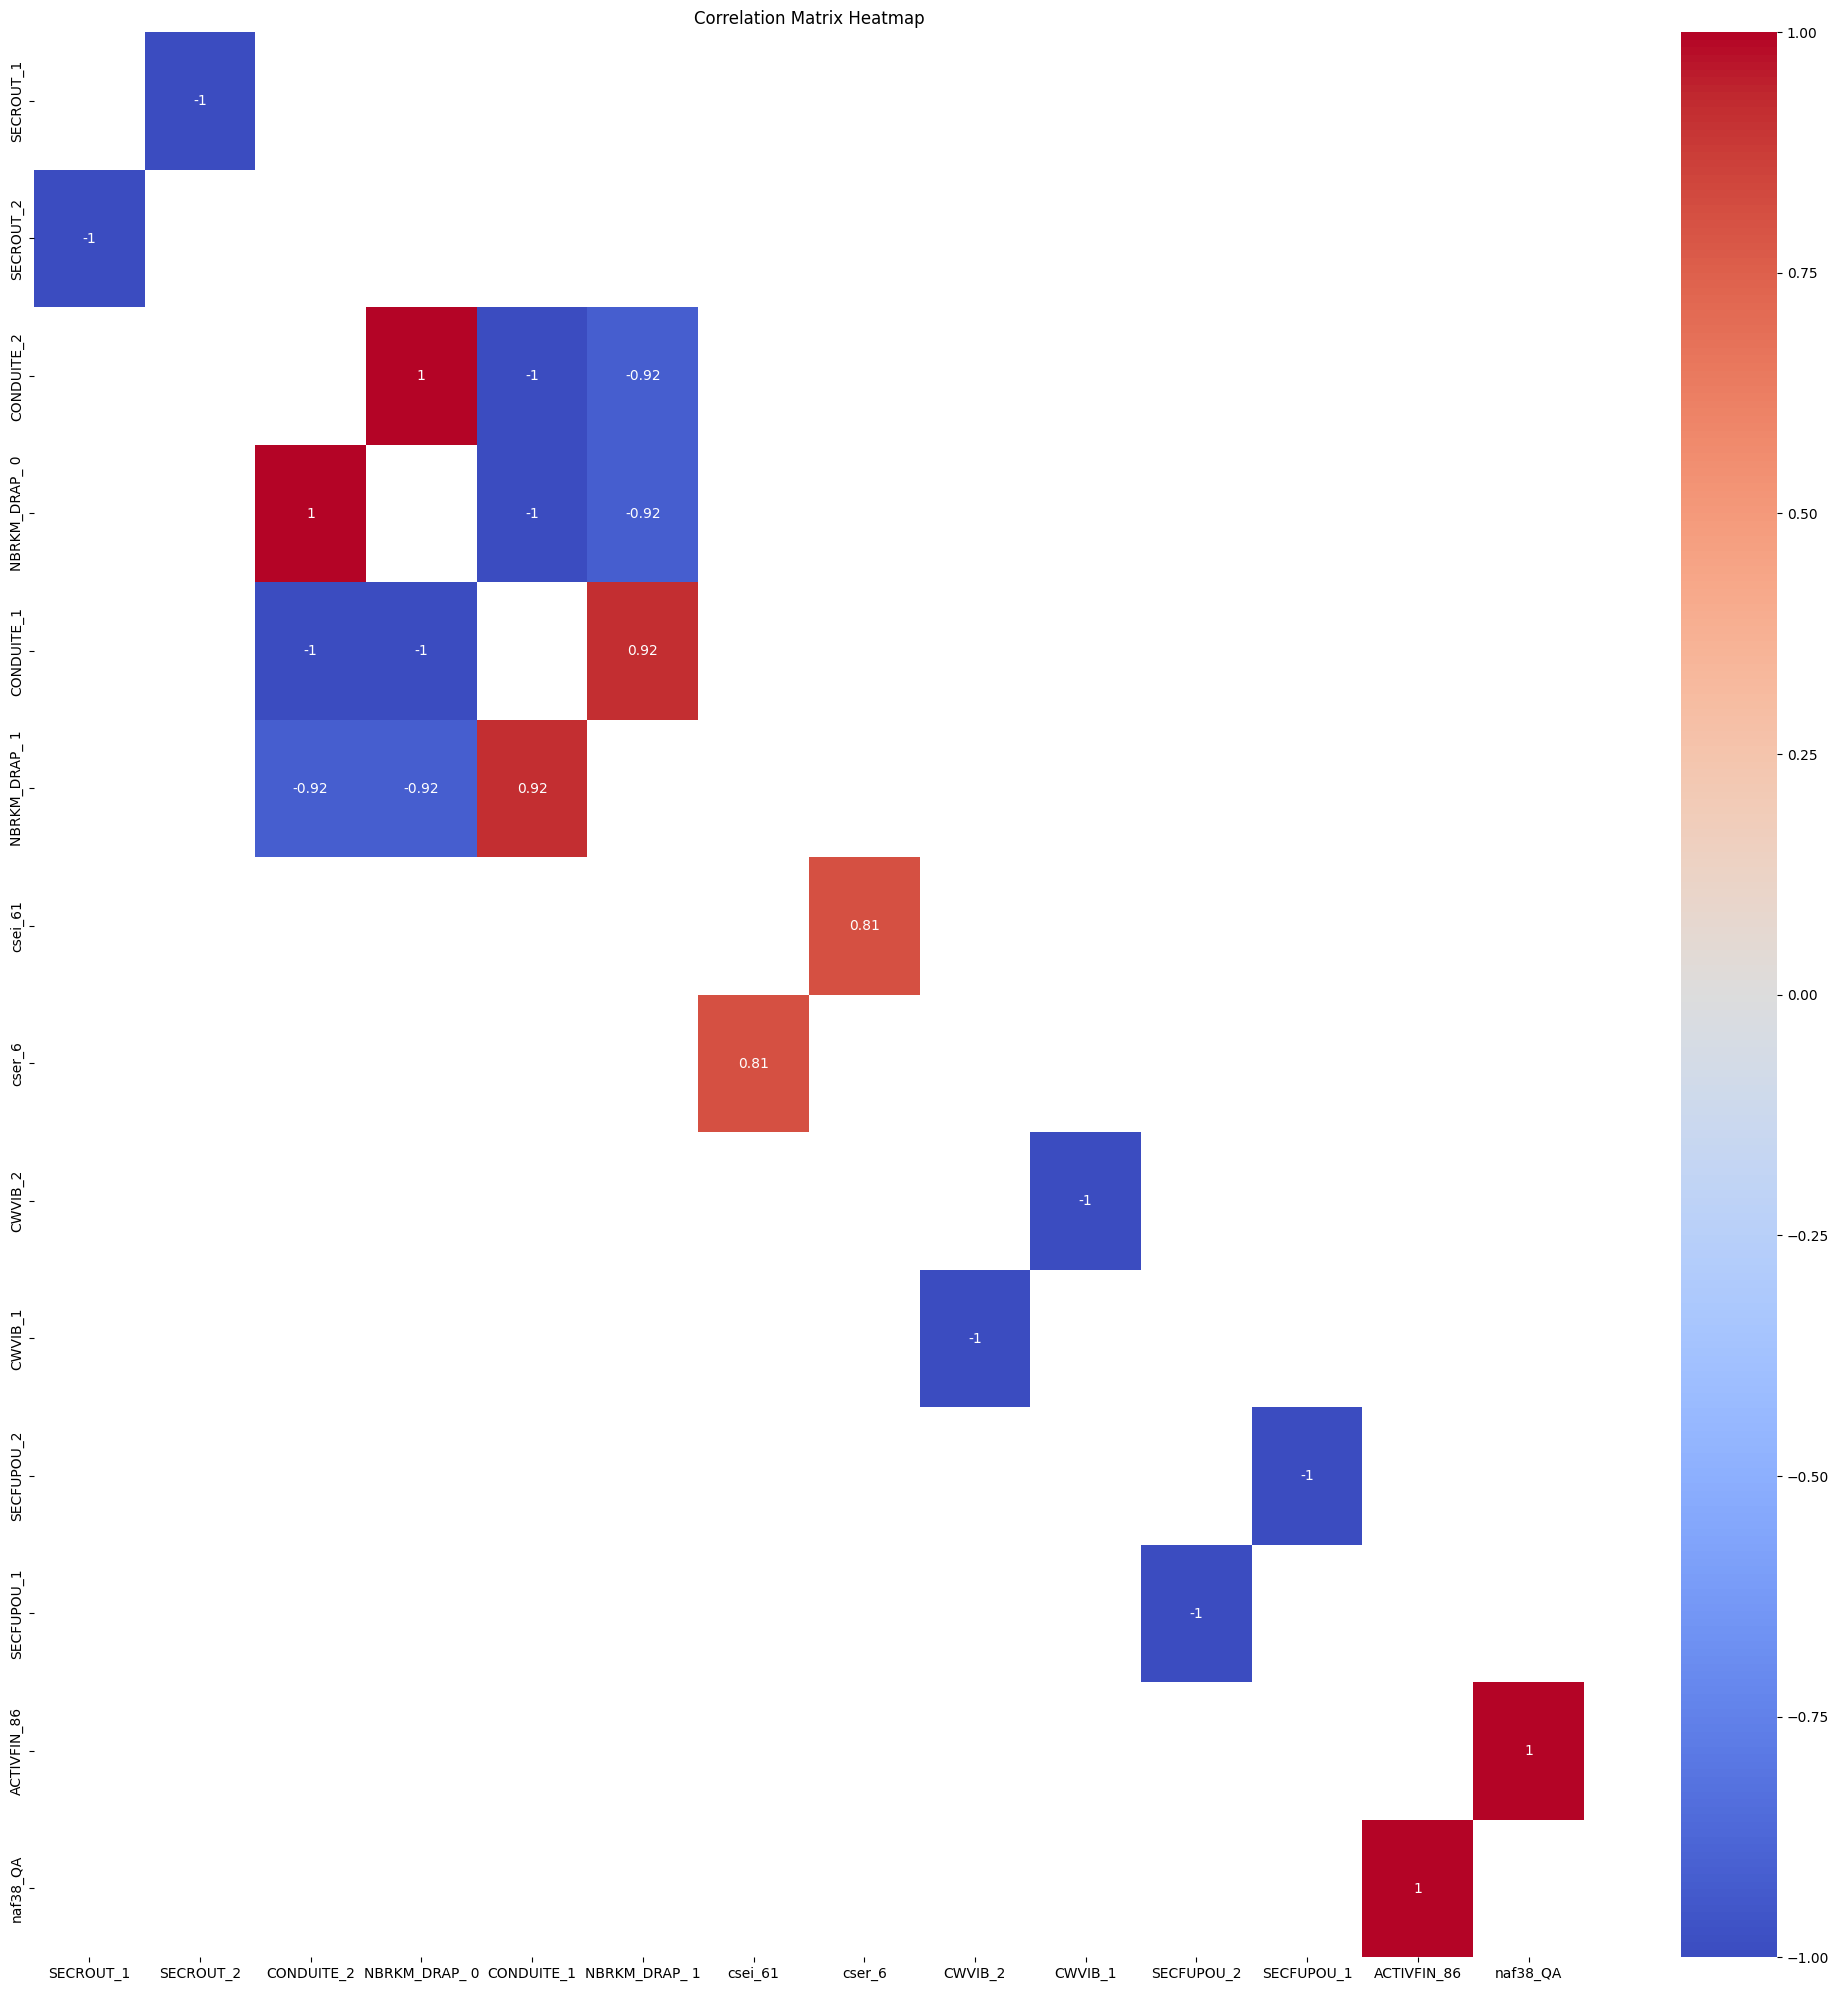

In [161]:
# Create a heatmap of the filtered correlation matrix
plt.figure(figsize=(25, 25))
sns.heatmap(filtered_corr_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Matrix Heatmap")
plt.show()

##### Using the dictionnary we eliminate highly correlated variables.

In [162]:
one_hot_df.drop(
    columns=[
        "SECROUT_1",
        "CONDUITE_2",
        "NBRKM_DRAP_ 0",
        "NBRKM_DRAP_ 1",
        "CWVIB_1",
        "SECFUPOU_2",
        "ACTIVFIN_86",
        "csei_61",
    ],
    inplace=True,
)

/tmp/ipykernel_160722/847262101.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



---

### B. Data Standardization

##### The quantiative data has a high variance which is why we apply a standardization to have a mean of 0 and a standard deviation of 1

In [163]:
def standard_columns(column):
    return (column - column.mean()) / column.std() 

# Standardize the quantitative variables
one_hot_df[one_hot_df.select_dtypes(["int", "float"]).columns] = one_hot_df[
    one_hot_df.select_dtypes(["int", "float"]).columns 
].apply(standard_columns)

/tmp/ipykernel_160722/3478200850.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



---

### C. Model creation & fitting

In [164]:
print(f"The final list of columns to be used in the model: {one_hot_df.columns.tolist()}")

The final list of columns to be used in the model: ['TPP_1', 'SECROUT_2', 'cser_5', 'naf4_EV', 'CONDUITE_1', 'naf17_OQ', 'CJSITUA_6', 'TINA_3', 'cser_6', 'CWVIB_2', 'SECFUPOU_1', 'naf38_QA', 'HH', 'KMANNU', 'REVMENS', 'target']


##### We will use a Logistic Regression model more known as 'logi' through the statsmodels library

In [165]:
col_target = "target"
col_features = one_hot_df.columns.tolist()[:-1] # Get all the columns except the target column

X = np.array(one_hot_df[col_features]).astype(float) # Convert the features to a numpy array
y = np.array(one_hot_df[col_target]) # Convert the target to a numpy array

model = sm.Logit(y, X) # Create a logistic regression model
result = model.fit() # Fit the model

summary = result.summary() # Get the summary of the model
summary

Optimization terminated successfully.
         Current function value: 0.461927
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                22306
Model:                          Logit   Df Residuals:                    22291
Method:                           MLE   Df Model:                           14
Date:                Sun, 07 Jul 2024   Pseudo R-squ.:                  0.3080
Time:                        16:51:25   Log-Likelihood:                -10304.
converged:                       True   LL-Null:                       -14889.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.7776      0.053     14.616      0.000       0.673       0.882
x2            -0.8112      0.045    -18.215      0.000      -0.898      -0.724
x3            -0.6498      0.046    -14.083      0.000      -0.740      -0.559
x4            -0.6687      0.046    -14.599      0.000      -0.758      -0.579
x5             0.0232      0.043      0.538      0.590      -0.061       0.108
x6            -0.3162      0.044     -7.200      0.000      -0.402      -0.230
x7             2.9232      0.118     24.679      0.000       2.691       3.155
x8             0.9319      0.047     19.830      0.000       0.840       1.024
x9             0.4454      0.052      8.528      0.000       0.343       0.548
x10           -0.8480      0.046    -18.246      0.000      -0.939      -0.757
x11            0.1334      0.041      3.264      0.001       0.053       0.213
x12           -0.7799      0.060    -12.975      0.000      -0.898      -0.662
x13            0.1335      0.021      6.320      0.000       0.092       0.175
x14            0.1506      0.023      6.659      0.000       0.106       0.195
x15            1.1901      0.053     22.318      0.000       1.086       1.295
==============================================================================
"""

##### From the model summary we can see that the coefficient of the 5th variable: **'CONDUITE_1'** has a **p-value** of **0.59** meaning it is highly insignificant which is why we decided to drop it. 

In [166]:
one_hot_df.drop(columns=["CONDUITE_1"], inplace=True)

/tmp/ipykernel_160722/3206857883.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



##### We'll also try adding a constant to the model

In [167]:
col_target = "target"
col_features = one_hot_df.columns.tolist()[:-1]

X = np.array(one_hot_df[col_features]).astype(float)
y = np.array(one_hot_df[col_target])
X = sm.add_constant(X)
model = sm.Logit(y, X)
result = model.fit()

summary = result.summary()
summary

Optimization terminated successfully.
         Current function value: 0.453739
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                22306
Model:                          Logit   Df Residuals:                    22291
Method:                           MLE   Df Model:                           14
Date:                Sun, 07 Jul 2024   Pseudo R-squ.:                  0.3202
Time:                        16:51:26   Log-Likelihood:                -10121.
converged:                       True   LL-Null:                       -14889.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.8818      0.102    -18.423      0.000      -2.082      -1.682
x1             1.4514      0.069     21.085      0.000       1.316       1.586
x2            -0.7051      0.039    -18.221      0.000      -0.781      -0.629
x3            -0.5729      0.047    -12.237      0.000      -0.665      -0.481
x4            -0.3539      0.049     -7.295      0.000      -0.449      -0.259
x5            -0.3076      0.045     -6.903      0.000      -0.395      -0.220
x6             3.0443      0.122     25.002      0.000       2.806       3.283
x7             1.3918      0.056     24.936      0.000       1.282       1.501
x8             0.6340      0.053     11.898      0.000       0.530       0.738
x9            -0.3864      0.052     -7.411      0.000      -0.489      -0.284
x10            0.3868      0.043      9.082      0.000       0.303       0.470
x11           -0.7463      0.060    -12.368      0.000      -0.865      -0.628
x12            0.0930      0.021      4.353      0.000       0.051       0.135
x13            0.2008      0.023      8.817      0.000       0.156       0.245
x14            1.1230      0.053     21.190      0.000       1.019       1.227
==============================================================================
"""

##### **Results Analysis**: 
- The logistic regression model has a **Pseudo R-squared of 0.32** meaning it explains through the 14 provided variables **32%** of the variance in our target variable.
- The **LLR p-value** and the **p-values** of the coeficients are all < 0.05 meaning that our model is **highly statistically significant**.
- We can see that **Log-Likelihood > LL-Null** suggesting that the chosen variables **significantly improve the model's ability to predict the outcome variable**.

---

### D. Model Optimization

##### We aim to streamline our model by reducing the number of variables while maintaining high performance. Our approach involves systematically testing various combinations of selected variables to strike an optimal balance between model complexity and predictive accuracy. This process will help identify the most influential predictors while ensuring the model remains robust and effective in its predictions.

In [168]:
import itertools
from joblib import Parallel, delayed
from tqdm import tqdm

col_target = "target"
col_features = one_hot_df.columns.tolist()[:-1]
y_np = np.array(one_hot_df[col_target]) # Convert the target to a numpy array


def fit_model(subset_features):
    """
    Fits a logistic regression model and returns pseudo R-squared.

    Args:
    - features (list): Feature names.

    Returns:
    - tuple: (features, pseudo R-squared).
    """

    X_subset = np.array(one_hot_df[list(subset_features)]).astype(float) # Convert the features to a numpy array
    X_subset = sm.add_constant(X_subset)
    model = sm.Logit(y_np, X_subset)
    result = model.fit(disp=False)
    return subset_features, result.prsquared


# Generate all possible combinations of col_features
all_combinations = []
for i in range(1, len(col_features) + 1):
    for subset_features in itertools.combinations(col_features, i):
        all_combinations.append(subset_features) # Append the subset to the list

# Parallel processing with tqdm progress bar
num_cores = 4 # Number of cores to use for parallel processing
results = Parallel(n_jobs=num_cores)(
    delayed(fit_model)(subset)
    for subset in tqdm(all_combinations, desc="Processing combinations")
)

# Extract results
combinations, r_squared_values = zip(*results)

# Create a DataFrame to display the results
results_df = pd.DataFrame(
    {"Features": combinations, "Pseudo R-squared": r_squared_values}
)

results_df

Processing combinations:   0%|          | 0/16383 [00:00<?, ?it/s]

Processing combinations: 100%|██████████| 16383/16383 [11:17<00:00, 24.17it/s]


,Features,Pseudo R-squared
0,"(TPP_1,)",0.084428
1,"(SECROUT_2,)",0.059901
2,"(cser_5,)",0.070238
3,"(naf4_EV,)",0.056070
4,"(naf17_OQ,)",0.048079
...,...,...
16378,"(TPP_1, SECROUT_2, cser_5, naf17_OQ, CJSITUA_6...",0.318455
16379,"(TPP_1, SECROUT_2, naf4_EV, naf17_OQ, CJSITUA_...",0.315089
16380,"(TPP_1, cser_5, naf4_EV, naf17_OQ, CJSITUA_6, ...",0.309135
16381,"(SECROUT_2, cser_5, naf4_EV, naf17_OQ, CJSITUA...",0.302536


In [169]:
results_df = results_df.sort_values(by="Pseudo R-squared", ascending=False)
results_df.head(10)

,Features,Pseudo R-squared
16382,"(TPP_1, SECROUT_2, cser_5, naf4_EV, naf17_OQ, ...",0.320244
16370,"(TPP_1, SECROUT_2, cser_5, naf4_EV, naf17_OQ, ...",0.319610
16377,"(TPP_1, SECROUT_2, cser_5, naf4_EV, CJSITUA_6,...",0.318637
16378,"(TPP_1, SECROUT_2, cser_5, naf17_OQ, CJSITUA_6...",0.318455
16373,"(TPP_1, SECROUT_2, cser_5, naf4_EV, naf17_OQ, ...",0.318402
16324,"(TPP_1, SECROUT_2, cser_5, naf17_OQ, CJSITUA_6...",0.317755
16315,"(TPP_1, SECROUT_2, cser_5, naf4_EV, CJSITUA_6,...",0.317705
16289,"(TPP_1, SECROUT_2, cser_5, naf4_EV, naf17_OQ, ...",0.317676
16372,"(TPP_1, SECROUT_2, cser_5, naf4_EV, naf17_OQ, ...",0.317498
16369,"(TPP_1, SECROUT_2, cser_5, naf4_EV, naf17_OQ, ...",0.317233


In [170]:
# Add a Number of Features Variable
results_df["Num Features"] = results_df["Features"].apply(len)
results_df

,Features,Pseudo R-squared,Num Features
16382,"(TPP_1, SECROUT_2, cser_5, naf4_EV, naf17_OQ, ...",0.320244,14
16370,"(TPP_1, SECROUT_2, cser_5, naf4_EV, naf17_OQ, ...",0.319610,13
16377,"(TPP_1, SECROUT_2, cser_5, naf4_EV, CJSITUA_6,...",0.318637,13
16378,"(TPP_1, SECROUT_2, cser_5, naf17_OQ, CJSITUA_6...",0.318455,13
16373,"(TPP_1, SECROUT_2, cser_5, naf4_EV, naf17_OQ, ...",0.318402,13
...,...,...,...
8,"(CWVIB_2,)",0.044554,1
7,"(cser_6,)",0.042976,1
9,"(SECFUPOU_1,)",0.040610,1
12,"(KMANNU,)",0.038618,1


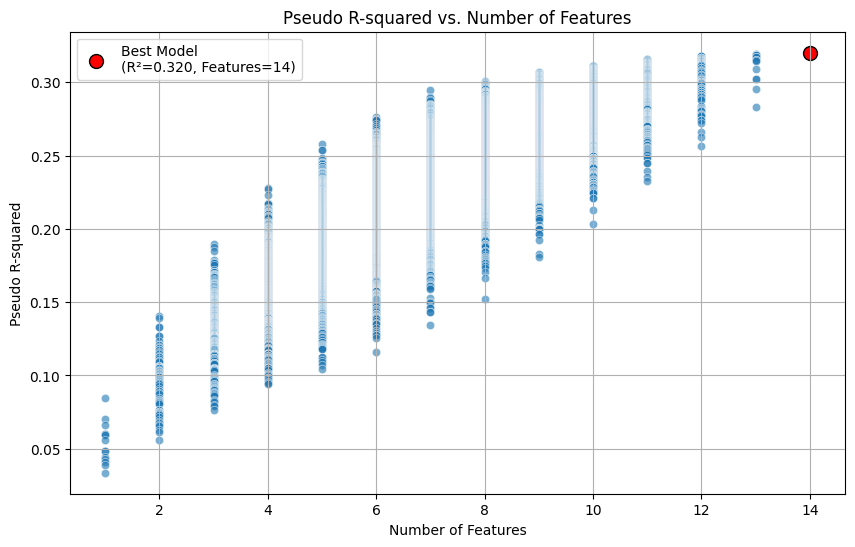

In [171]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(
    results_df["Num Features"],
    results_df["Pseudo R-squared"],
    alpha=0.6, # Set the transparency of the points for visibility due to the overlapping points
    edgecolors="w",
    linewidth=0.5,
)
plt.xlabel("Number of Features")
plt.ylabel("Pseudo R-squared")
plt.title("Pseudo R-squared vs. Number of Features")
plt.grid(True)

# Highlight the best model
best_model_idx = results_df["Pseudo R-squared"].idxmax()
best_model_r2 = results_df.loc[best_model_idx, "Pseudo R-squared"]
best_model_features = results_df.loc[best_model_idx, "Num Features"]
plt.scatter(
    best_model_features,
    best_model_r2,
    color="red",
    s=100,
    edgecolors="k",
    label=f"Best Model\n(R²={best_model_r2:.3f}, Features={best_model_features})",
)

plt.legend()
plt.show()

##### Using the above plot we can see that even with **less features**, there are combinations that offer a similarly high R²

In [172]:
# Extract the best models for each number of features
best_models = results_df.loc[
    results_df.groupby("Num Features")["Pseudo R-squared"].idxmax()
]
best_models

,Features,Pseudo R-squared,Num Features
0,"(TPP_1,)",0.084428,1
18,"(TPP_1, CJSITUA_6)",0.140544,2
119,"(TPP_1, cser_5, CJSITUA_6)",0.190021,3
471,"(TPP_1, SECROUT_2, cser_5, CJSITUA_6)",0.227992,4
1489,"(TPP_1, SECROUT_2, cser_5, CJSITUA_6, TINA_3)",0.258208,5
3517,"(TPP_1, SECROUT_2, cser_5, naf17_OQ, CJSITUA_6...",0.276181,6
7020,"(TPP_1, SECROUT_2, naf17_OQ, CJSITUA_6, TINA_3...",0.294518,7
10122,"(TPP_1, SECROUT_2, cser_5, naf17_OQ, CJSITUA_6...",0.300685,8
13170,"(TPP_1, SECROUT_2, cser_5, naf17_OQ, CJSITUA_6...",0.306971,9
15134,"(TPP_1, SECROUT_2, cser_5, naf17_OQ, CJSITUA_6...",0.311476,10


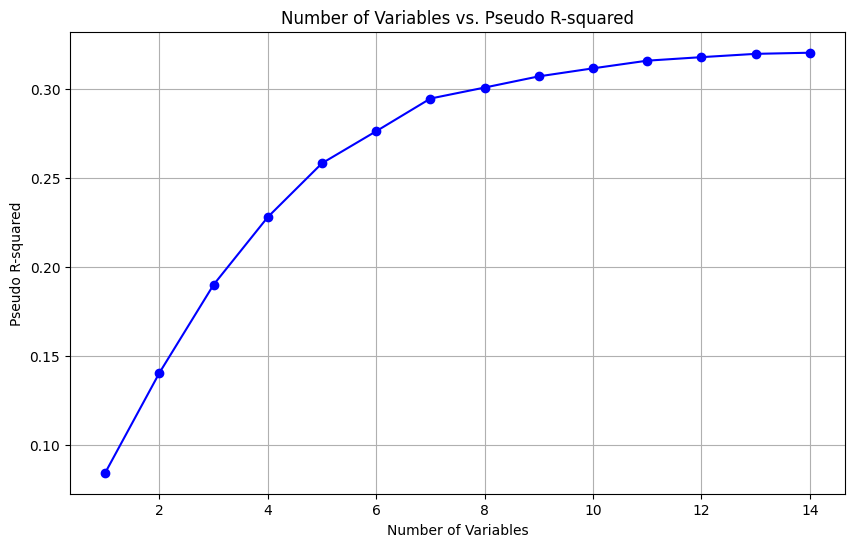

In [174]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(
    best_models["Num Features"],
    best_models["Pseudo R-squared"],
    marker="o",
    linestyle="-",
    color="b",
)
plt.title("Number of Variables vs. Pseudo R-squared")
plt.xlabel("Number of Variables")
plt.ylabel("Pseudo R-squared")
plt.grid(True)
plt.show()

##### From the following graph we can choose a number of variables that also offers a performant model. We chose the **7** variables listed below

In [175]:
best_features = list(best_models.iloc[6]["Features"])
best_features

['TPP_1', 'SECROUT_2', 'naf17_OQ', 'CJSITUA_6', 'TINA_3', 'cser_6', 'REVMENS']

##### We retrain a model with the final chosen combination of variables

In [176]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

col_target = "target"
col_features = best_features
X = one_hot_df[col_features].astype(float)
X = sm.add_constant(X)
X_train, X_test, y_train, y_test = train_test_split(
    X, one_hot_df[col_target], test_size=0.2, random_state=42
)
model = sm.Logit(y_train, X_train)
result = model.fit()
summary = result.summary()
summary

Optimization terminated successfully.
         Current function value: 0.470935
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                17844
Model:                          Logit   Df Residuals:                    17836
Method:                           MLE   Df Model:                            7
Date:                Sun, 07 Jul 2024   Pseudo R-squ.:                  0.2945
Time:                        17:03:35   Log-Likelihood:                -8403.4
converged:                       True   LL-Null:                       -11910.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.4526      0.091    -26.926      0.000      -2.631      -2.274
TPP_1          1.6284      0.071     23.075      0.000       1.490       1.767
SECROUT_2     -1.0821      0.039    -27.899      0.000      -1.158      -1.006
naf17_OQ      -0.8505      0.040    -21.376      0.000      -0.928      -0.772
CJSITUA_6      3.0820      0.135     22.867      0.000       2.818       3.346
TINA_3         1.4998      0.061     24.394      0.000       1.379       1.620
cser_6         1.1193      0.052     21.421      0.000       1.017       1.222
REVMENS        1.3330      0.057     23.295      0.000       1.221       1.445
==============================================================================
"""

##### The model is still performant and significant

---

### E. Model testing


In [177]:
# Import the necessary libraries for model testing
from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_score,
    recall_score,
    f1_score,
)
from sklearn.calibration import calibration_curve

#### 0- Predictions:

In [178]:
# Make the predictions using the model 
y_pred_proba = [] # Create an empty list to store the predicted probabilities
for i in range(0, len(X_test)):
    y_pred_proba.append(result.predict(X_test.iloc[i].values))
y_pred = (np.array(y_pred_proba) > 0.5).astype(int) # Convert the predicted probabilities to binary values

#### 1- Precision, Recall & F1 Metrics:

In [179]:
# Calculate precision, recall, and F1 score metrics for the model
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 0.7225063938618926
Recall: 0.653556969346443
F1 Score: 0.6863042818098998


#### 2- Confusion Matrix:

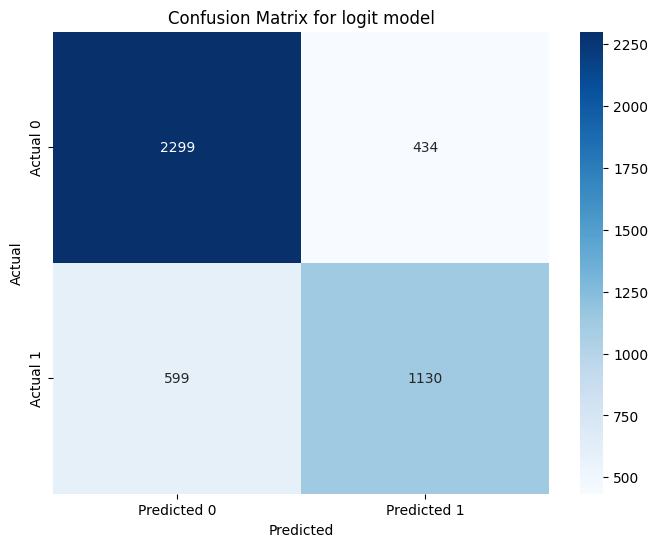

In [180]:

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Predicted 0", "Predicted 1"],
    yticklabels=["Actual 0", "Actual 1"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for logit model")
plt.show()

It looks like the model is better at predicting negative instances (Predicted 0) than positive instances (Predicted 1).
This could also be caused by a classes imbalance which needs further processing.



#### 3- ROC Curve & ROC-AUC metric:

ROC AUC Score: 0.85


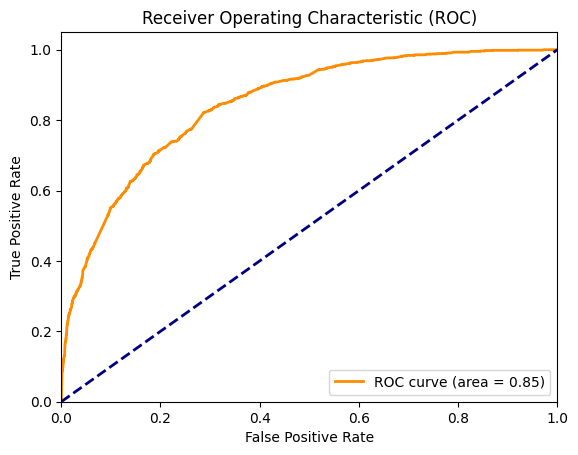

In [181]:
# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC Score: {roc_auc:.2f}")

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
# Plotting ROC curve
plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.show()

With a ROC AUC of 0.85 we can say that the model performs well in distinguishing between the two classes

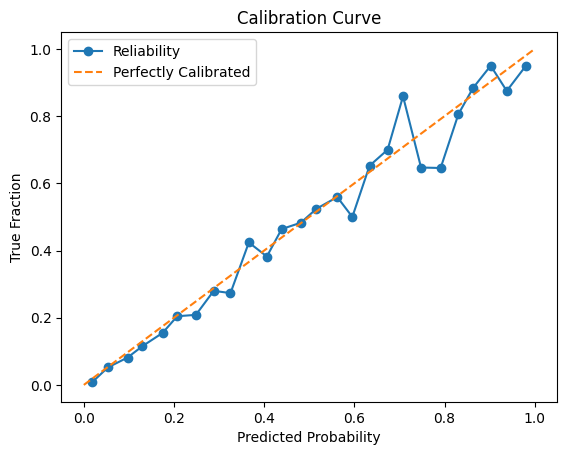

In [182]:
# Calculate the calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=26)

# Plot the calibration curve
plt.plot(prob_pred, prob_true, marker="o", label="Reliability")
plt.plot([0, 1], [0, 1], linestyle="--", label="Perfectly Calibrated")
plt.xlabel("Predicted Probability")
plt.title("Calibration Curve")
plt.ylabel("True Fraction")
plt.legend()
plt.show()

The graph shows that the model’s predictions are well calibrated, meaning that the predicted probability of an event closely matches the actual probability of the event. The reliability is high throughout, which means the model is consistently good at making these predictions excpet some minor disturbances at predictions with probabilities between 0.6 & 0.8.

---

## 5. Conclusion

##### After multiple levels of feature selection, model fitting & optimization we found the following variables to be the determinants for a woman being the primary source of revenue in the household:
### **Work Characteristics:**

- **Full-time Work (TPP_1)**: Women who work full-time (TPP_1) are more likely to assume the role of primary source of revenue, as indicated by its positive coefficient of (1.62).
- **Workplace Risk (SECROUT_2)**: The absence of high-risk workplace conditions (SECROUT_2) correlates negatively with the likelihood of a woman being the primary source of revenue (-1.08).

### **Occupational Factors:**

- **Industry Sector (naf17_OQ)**: Engaging in administrative activities, education, or health sectors (naf17_OQ) corresponds to a decrease in the likelihood (-0.85) of a woman being the primary source of revenue.
- **Socio-Professional Category (cser_6)**: Occupying blue-collar positions (cser_6), such as 'Ouvrier', is associated with a higher probability (1.12) of being the primary source of revenue.

### **Family and Career Dynamics:**

- **Spouse's Work Situation (CJSITUA_6)**: Having an inactive spouse (CJSITUA_6), such as one who is a homemaker or retired, significantly increases the odds (3.08) of a woman being the primary source of revenue.
- **Career Breaks (TINA_3)**: Never having taken extended breaks from work (TINA_3) positively influences (1.5) the likelihood of being the primary source of revenue.

### **Income Considerations:**

- **Monthly Income (REVMENS)**: Higher net monthly income (REVMENS) positively impacts (1.33) the likelihood of a woman being the primary source of revenue.

These variables collectively provide insights into the socioeconomic factors influencing the likelihood of a woman being the primary source of revenue in a household, highlighting both occupational and household dynamics impacting income and employment roles.

